In [3]:
# Import necessary libraries

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy import interpolate

import math
#from itertools import zip

In [9]:
# param
Temp = [-40, 20, 80, 160] #°C
Npp = 5
Nsp = 98
Imax = 20
Umax = 24 #alim 24V - pertes?

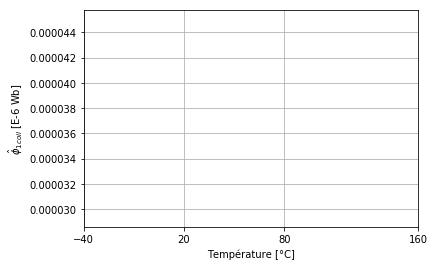

In [13]:
# Flux
phi = np.array([45.78, 40.11, 35.60, 28.55])*1E-6 #[-40, 20, 80, 160]°C
Lq = np.array([7.42, 7.60, 7.77, 8.04])*1E-4


plt.plot(Temp,phi*1E+6,'o-')
plt.xlabel("Température [°C]")
plt.ylabel("$\hat{\phi}_{1coil}$ [E-6 Wb]")
plt.xlim([min(Temp),max(Temp)])
plt.ylim([min(phi),max(phi)])
plt.xticks(Temp)
#plt.legend(loc="best")
plt.grid()
#plt.savefig("Phi_motor"+".pdf")

R0: [3.963e-05 5.186e-05 6.409e-05 8.039e-05] 
R:  [0.381 0.498 0.615 0.772]


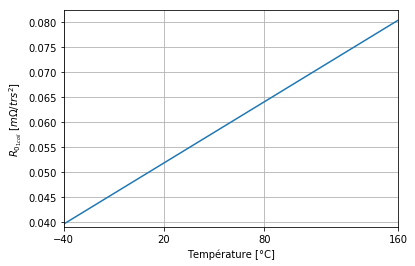

In [7]:
#Resistance
w = 4.4E-3 # stator dent[3mm, 4mm]
h = 24.55E-3
th = 4.75E-3
l = 9E-3
sigma = 0.565

rho = []
for t in Temp:
    rho.append(1.72E-8*(1 + (t-20)*0.00393))# [-40, 20, 80, 160]°C
    
R0 = [] # 3mm
for rho_t in rho:
    R0.append(rho_t*(2*(w+h)+math.pi*th)/(sigma*th*l))

R = np.array(R0)*Nsp**2

print("R0:",np.array(R0).round(8),"\nR: ",R.round(3))

plt.plot(Temp,np.array(R0)*1000)
plt.xlabel("Température [°C]")
plt.ylabel("$R_{0_{1coil}}$ [$m\Omega$/$trs^2$]")
plt.xlim([min(Temp),max(Temp)])
plt.ylim(bottom=0.039)
plt.xticks(Temp)
plt.grid()
#plt.savefig("R0.pdf")
plt.show()

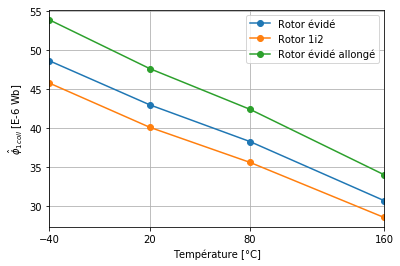

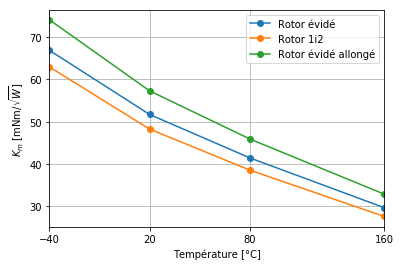

In [188]:
# Km
to_plot = ["Rotor évidé", "Rotor 1i2", "Rotor évidé allongé"]

    
Km = math.sqrt(3)*phi*Npp/math.sqrt(R0)
    
plt.figure("phi")

    
plt.figure("Km")
plt.plot(Temp,Km*1000,'o-')
    

    
plt.figure("Km")
plt.xlabel("Température [°C]")
plt.ylabel("$K_m$ [mNm/$\sqrt{W}$]")
plt.xlim([min(Temp),max(Temp)])
plt.ylim(bottom=25)
plt.xticks(Temp)
plt.legend(loc="best")
plt.grid()
plt.savefig("Km_motor"+".pdf")
plt.show()

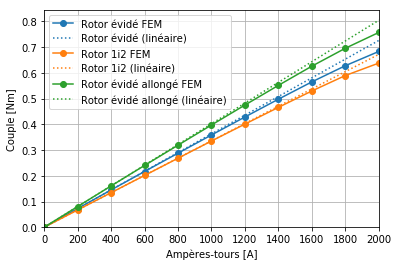

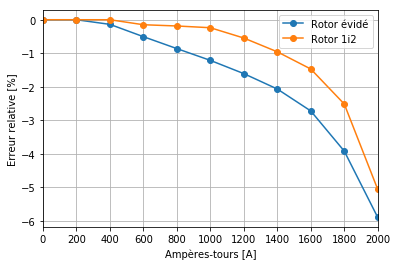

In [189]:
# Torque vs current

I = range(0,2001,200) # Ampere tour
# Couple 20°C
c_1i2 = np.array([0, 6.72, 13.44, 20.13, 26.83, 33.52, 40.10, 46.59, 52.97, 58.96, 63.80])*1E-2
c_évidé = np.array([0, 7.26, 14.50, 21.67, 28.79, 35.86, 42.86, 49.77, 56.50, 62.78, 68.32])*1E-2
c_évidé_l = facteur_v_allonge*c_évidé 

c = [c_évidé, c_1i2, c_évidé_l]

plt.figure("Torque")
plt.figure("Err_rel")

err_rel_lin = []
to_plot = ["Rotor évidé", "Rotor 1i2", "Rotor évidé allongé"]
for i, elem_to_plot in enumerate(to_plot):
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    couple_fem = c[i]
    couple_lin = c[i][0]+(c[i][1]-c[i][0])/(I[1]-I[0])*I
    
    err_rel_lin.append([0]+list((couple_fem[1:]-couple_lin[1:])/couple_lin[1:]*100))
    
    plt.figure("Torque")
    plt.plot(I,couple_fem, 'o-', color=color,label=elem_to_plot+" FEM")
    plt.plot(I,couple_lin,':', color=color, label=elem_to_plot+ " (linéaire)")
    
    plt.figure("Err_rel")
    if elem_to_plot != "Rotor évidé allongé":
        plt.plot(I,err_rel_lin[i], 'o-', color=color,label=elem_to_plot)

plt.figure("Torque")
plt.xlabel("Ampères-tours [A]")
plt.ylabel("Couple [Nm]")
plt.xlim([min(I), max(I)])
plt.ylim(bottom=0)
plt.xticks(I)
plt.legend(loc="best")
plt.grid()
plt.savefig("Couple_courant"+".pdf")

plt.figure("Err_rel")
plt.xlabel("Ampères-tours [A]")
plt.ylabel("Erreur relative [%]")
plt.xlim([min(I), max(I)])
#plt.ylim([35,50])
plt.xticks(I)
plt.legend(loc="best")
plt.grid()
plt.savefig("Couple_courant_err"+".pdf")
plt.show()

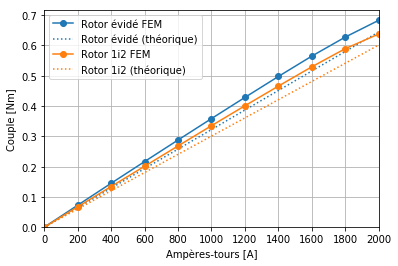

Ecart rel Rotor évidé:  [0, 12.6, 12.4, 12.0, 11.6, 11.2, 10.8, 10.3, 9.5, 8.2, 5.9]
Ecart rel Rotor 1i2:  [0, 11.7, 11.7, 11.5, 11.5, 11.4, 11.1, 10.6, 10.1, 8.9, 6.0]


In [190]:
# Torque vs current (FEM vs Torque=phi)
to_plot = ["Rotor évidé", "Rotor 1i2"]
ecart_rel = []
for i, elem_to_plot in enumerate(to_plot):
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(I,c[i], 'o-', color=color,label=elem_to_plot+" FEM")
    T_foc = 3/2*Npp*phi[i][1]*np.array(I)
    plt.plot(I, T_foc, ':', color=color, label=elem_to_plot+ " (théorique)")
    
    ecart_rel.append([0]+list(np.round((c[i]-T_foc)[1:]/T_foc[1:]*100,decimals=1)))

plt.xlabel("Ampères-tours [A]")
plt.ylabel("Couple [Nm]")
plt.xlim([min(I),max(I)])
plt.xticks(I)
plt.legend(loc="best")
plt.ylim(bottom=0)
plt.grid()
plt.savefig("Couple_courant_phi"+".pdf")
plt.show()

print("Ecart rel %s: "%(to_plot[0]),ecart_rel[0])
print("Ecart rel %s: "%(to_plot[1]),ecart_rel[1])

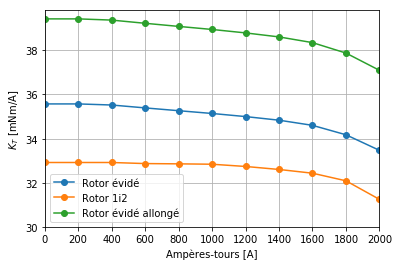

In [191]:
# Kt FEM
to_plot = ["Rotor évidé", "Rotor 1i2", "Rotor évidé allongé"]

for i, elem_to_plot in enumerate(to_plot):
    plt.plot(I,np.concatenate(([c[i][1]/I[1]], (c[i][1:]/I[1:])))*1000*Nsp,'o-',label=elem_to_plot)

plt.xlabel("Ampères-tours [A]")
plt.ylabel("$K_T$ [mNm/A]")
plt.xlim([min(I),max(I)])
plt.ylim(bottom=30)
plt.xticks(I)
plt.legend(loc="lower left")
plt.grid()
plt.savefig("Kt_motor_I"+".pdf")
plt.show()

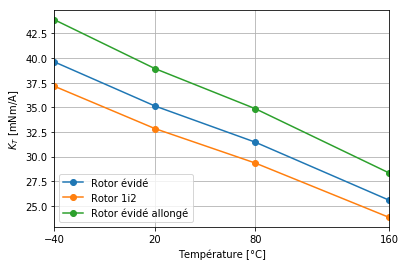

In [60]:
# Kt température

I_kt = 1000 #Applied current for torque

c_1i2_t = np.array([37.90, 33.52, 29.95, 24.32])*1E-2 # [-40, 20, 80, 160]
c_évidé_t = np.array([40.42, 35.86, 32.11, 26.10])*1E-2
c_évidé_l_t = facteur_v_allonge*c_évidé_t

c_t =  [c_évidé_t, c_1i2_t, c_évidé_l_t]
to_plot = ["Rotor évidé", "Rotor 1i2", "Rotor évidé allongé"]

KT_temp = []
for i, elem_to_plot in enumerate(to_plot):
    KT_temp.append(c_t[i]/I_kt*Nsp)
    plt.plot(Temp,KT_temp[i]*1000,'o-',label=elem_to_plot)

plt.xlabel("Température [°C]")
plt.ylabel("$K_T$ [mNm/A]")
plt.xlim([min(Temp), max(Temp)])
#plt.ylim(bottom=30)
plt.xticks(Temp)
plt.legend(loc="lower left")
plt.grid()
plt.savefig("Kt_motor_temp"+".pdf")
plt.show()

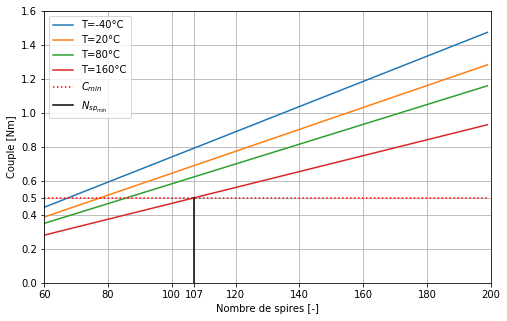

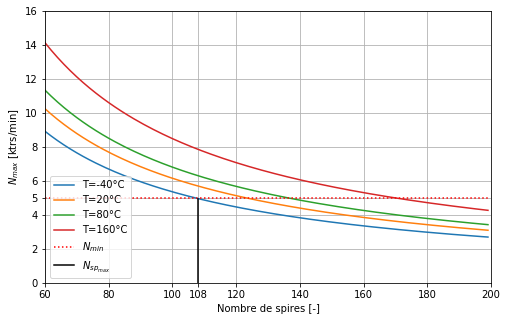

In [192]:
phi_m  = np.array([49.39, 42.99, 38.85, 31.17])*1E-6# Flux moyen évidé en fonction de la température 
Nsp_array = np.array(range(60,200))
Npp = 5
Imax = 20
U = 24 #alim 24V - pertes?

to_plot = ["-40", "20", "80", "160"] # Temperatures °C

T = [] # Torque
N = [] # Max_speed
plt.figure("T",figsize=(8,5)) # torque plot
plt.figure("N",figsize=(8,5)) # speed plot
for i,elem_to_plot in enumerate(to_plot):
    T.append(3/2*Nsp_array*Npp*phi_m[i]*Imax) # Torque formula
    N.append(30*U/(np.sqrt(3)*Nsp_array*Npp*phi_m[i]*math.pi)) # Max speed formula
    
    plt.figure("T") # switch plot
    plt.plot(Nsp_array,T[i],label="T=%s°C"%(elem_to_plot))

    plt.figure("N") # switch plot
    plt.plot(Nsp_array,N[i]/1000,label="T=%s°C"%(elem_to_plot))


#plot settings for torque
plt.figure("T")
plt.plot(Nsp_array,np.ones((len(Nsp_array),1))*0.5,"r:",label="$C_{min}$")

Nsp_min_pos = np.argmax(T[-1]>0.5)
plt.plot([Nsp_array[Nsp_min_pos], Nsp_array[Nsp_min_pos]],[0, T[-1][Nsp_min_pos]],"k",label="$N_{sp_{min}}$")

plt.xlim([60,Nsp_array.max()])
plt.ylim(bottom=0)
plt.xticks(list(plt.xticks()[0])+[Nsp_array[Nsp_min_pos]])
plt.yticks(list(plt.yticks()[0])+[0.5])
plt.xlabel("Nombre de spires [-]")
plt.ylabel("Couple [Nm]")

plt.legend(loc="best")
plt.grid()
plt.savefig("Nsp_torque.pdf")

# Plot settings for max speed
plt.figure("N")
plt.plot(Nsp_array,np.ones((len(Nsp_array),1))*5,"r:",label="$N_{min}$")

Nsp_max_pos = np.argmax(N[0]<5000)
plt.plot([Nsp_array[Nsp_max_pos], Nsp_array[Nsp_max_pos]],[0, N[0][Nsp_max_pos]/1000],"k",label="$N_{sp_{max}}$")

plt.xlim([60,Nsp_array.max()])
plt.ylim([0,15])
plt.xticks(list(plt.xticks()[0])+[Nsp_array[Nsp_max_pos]])
plt.yticks(list(plt.yticks()[0])+[5])
plt.xlabel("Nombre de spires [-]")
plt.ylabel("$N_{max}$ [ktrs/min]")

plt.legend(loc="lower left")
plt.grid()
plt.savefig("Nsp_speed.pdf")

plt.show()

   Unnamed: 1  Unnamed: 2
0           0    0.000001
1           1    0.000006
    Unnamed: 1    Unnamed: 2
71          71 -4.723506e-06
72          72 -6.588044e-08
   Unnamed: 1    Unnamed: 2
0           0  8.694076e-08
1           1  4.388030e-06
    Unnamed: 1    Unnamed: 2
71          71 -4.222087e-06
72          72  8.129147e-08


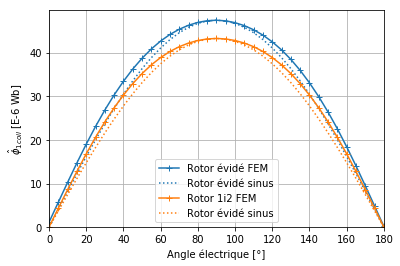

In [62]:
df_flux_evide = pd.read_excel("Flux_Evidee_support_fine.xls",skiprows=13,skipfooter=13).iloc[:,1:]
df_flux_1i2 = pd.read_excel("Flux_1i2_support_fine.xls",skiprows=13,skipfooter=13).iloc[:,1:]
print(df_flux_evide.head(2))
print(df_flux_evide.tail(2))
print(df_flux_1i2.head(2))
print(df_flux_1i2.tail(2))

angle_pos = df_flux_evide.iloc[:,0][:37]*Npp # angle electrique
flux_evide = df_flux_evide.iloc[:,1][:37]*1E+6
flux_1i2 = df_flux_1i2.iloc[:,1][:37]*1E+6

color = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot(angle_pos,flux_evide, "-+", color=color, label="Rotor évidé FEM")
plt.plot(angle_pos,max(abs(flux_evide))*np.sin(angle_pos/180*np.pi), ":", color=color, label="Rotor évidé sinus")

color = next(plt.gca()._get_lines.prop_cycler)['color']
plt.plot(angle_pos,flux_1i2,"-+", color=color, label="Rotor 1i2 FEM")
plt.plot(angle_pos,max(abs(flux_1i2))*np.sin(angle_pos/180*np.pi), ":", color=color, label="Rotor évidé sinus")

plt.xlim([min(angle_pos), max(angle_pos)])
plt.ylim(bottom=0)
#plt.yticks(list(plt.yticks()[0])+[5])
plt.xlabel("Angle électrique [°]")
plt.ylabel("$\hat{\phi}_{1coil}$ [E-6 Wb]")

plt.legend(loc="lower center")
plt.grid()
plt.savefig("Flux_FEM_sinus.pdf")
plt.show()

In [193]:
def N_speed (I,R1coil,L,phi):
    R = 3/4*R1coil
    
    ke = np.sqrt(3)*Nsp*Npp*phi
    
    part_a = (U*ke)**2+((L*I*Npp)**2)*(U**2-(R*I)**2)
    part_b = ke**2+(L*I*Npp)**2
    
    N = (30/np.pi)*(np.sqrt(part_a)-R*I*ke)/part_b
    
    return N

In [194]:
def Pertes (I, N, R1coil):
    # pertes fer
    Cp = 1.07
    k = 1.5 # 1.5-1.6
    fel = N/60*Npp
    Bmax = 1.5 # PAS JUSTE 
    mfer = 0.160
    
    Pfer = np.array(Cp*(fel/50)**k*(Bmax/1.5)**2*mfer)
    # pertes Joules
    cr = 3/4 # facteur 1coil - moteur resistance double etoile foc
    
    Pj = np.array(cr*R1coil*I**2)
    return Pfer+Pj

Temperature: 160°C
N_imax:  [2410. 2360. 2290. 2210.] 
N_max: [5550. 6280. 7060. 8790.]


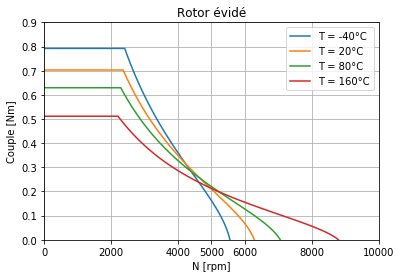

Temperature: 160°C
N_imax:  [2370. 2290. 2180. 2040.] 
N_max: [5900. 6730. 7590. 9460.]


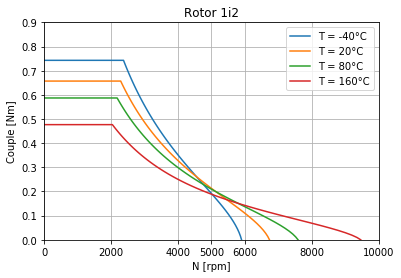

Temperature: 160°C
N_imax:  [2320. 2280. 2210. 2140.] 
N_max: [5010. 5670. 6370. 7940.]


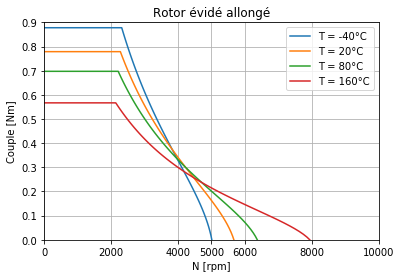

Temperature: 20°C
N_imax:  [2360. 2290. 2280.] 
N_max: [6280. 6730. 5670.]


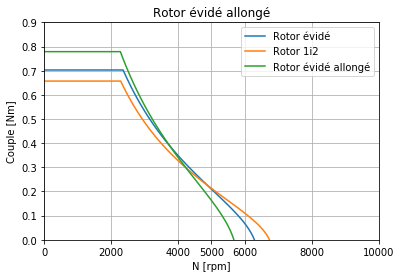

In [228]:
# Courbe T-w
to_plot =  ["Rotor évidé", "Rotor 1i2", "Rotor évidé allongé"]
file_name = ["si","1i2","si_allonge"]

I = np.linspace(20,0,50)
Lq = pd.DataFrame([[7.05E-4, 7.42E-4], #T-40 [rotor evide, rotor 1i2]
                   [7.05E-4, 7.60E-4], #T20
                   [7.05E-4, 7.77E-4], #T80
                   [7.05E-4, 8.04E-4]]) #T160
Lq[Lq.shape[1]] = 1*Lq.iloc[:,0] # ajouter inductance rotor evide allonge en fonction rotor evide * facteur
Lq = np.array(Lq)

N_imax = [[] for x in range(len(Temp))] # max speed with max current
N_max = [[] for x in range(len(Temp))] # max speed
N_lim = [[] for x in range(len(Temp))] # speed
T_lim = [[] for x in range(len(Temp))] # max torque

for i, elem_to_plot in enumerate(to_plot):
    for i_t, t_elem in enumerate(Temp):
        N_imax[i_t].append(N_speed(20,R[i_t],Lq[i_t,i],phi[i][i_t])) 
        N_max[i_t].append(N_speed(0,R[i_t],Lq[i_t,i],phi[i][i_t]))

        N_lim[i_t].append([0,N_imax[i_t][i]] + list(N_speed(I,R[i_t],Lq[i_t,i],phi[i][i_t])))
        T_lim[i_t].append(list(np.array([20,20])*KT_temp[i][i_t]) + list(I*KT_temp[i][i_t]))

        plt.plot(N_lim[i_t][i],T_lim[i_t][i], label = "T = %i°C"%(t_elem))


    plt.xlim([min(N_lim[i_t][i]),9.5E+3])
    plt.ylim([0,0.9])
    plt.xticks(list(plt.xticks()[0])+[5E+3])
    plt.xlabel("N [rpm]")
    plt.ylabel("Couple [Nm]")
    plt.title(elem_to_plot)

    plt.legend(loc="best")
    plt.grid()
    plt.savefig("Tw_%s_temp.pdf"%(file_name[i]))
    print("Temperature: %i°C"%(t_elem))
    print("N_imax: ",np.array(N_imax)[:,i].round(-1),"\nN_max:",np.array(N_max)[:,i].round(-1))
    plt.show()
    
for i, elem_to_plot in enumerate(to_plot):
    plt.plot(N_lim[1][i],T_lim[1][i], label = elem_to_plot)

plt.xlim([min(N_lim[i_t][i]),9.5E+3])
plt.ylim([0,0.9])
plt.xticks(list(plt.xticks()[0])+[5E+3])
plt.xlabel("N [rpm]")
plt.ylabel("Couple [Nm]")
plt.title(elem_to_plot)

plt.legend(loc="best")
plt.grid()
plt.savefig("Tw_comp_20C.pdf")
print("Temperature: %i°C"%(20))
print("N_imax: ",np.array(N_imax)[1,:].round(-1),"\nN_max:",np.array(N_max)[1,:].round(-1))
plt.show()

Temperature: -40°C
Rendement max Rotor évidé: 90.5
Rendement max Rotor 1i2: 90.1
Rendement max Rotor évidé allongé: 91.2


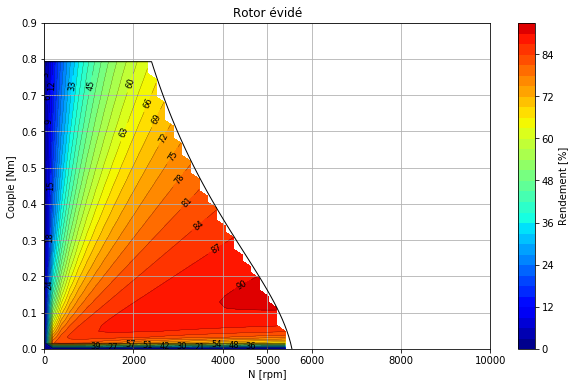

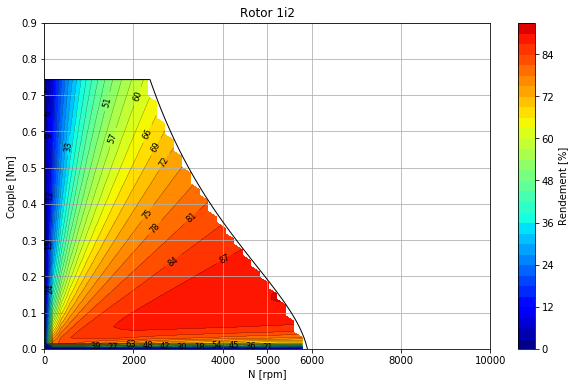

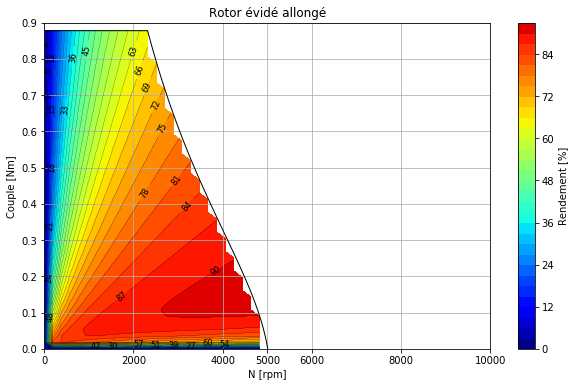

Temperature: 20°C
Skip
Temperature: 80°C
Skip
Temperature: 160°C
Rendement max Rotor évidé: 82.6
Rendement max Rotor 1i2: 81.7
Rendement max Rotor évidé allongé: 83.8


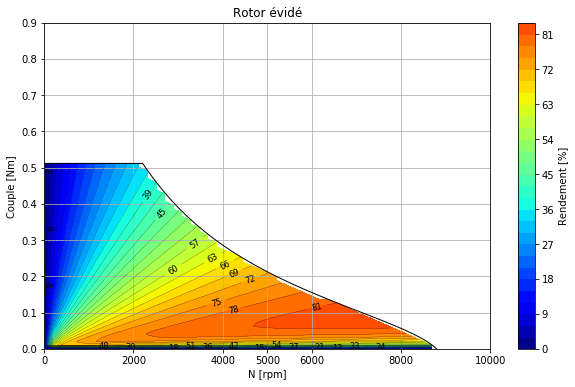

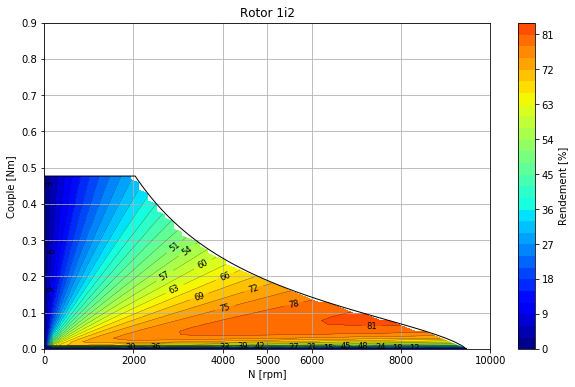

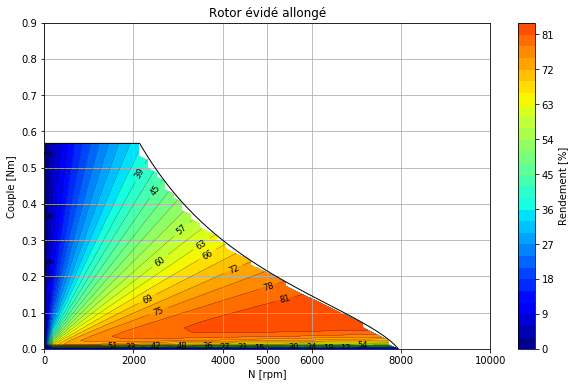

In [250]:
# T-w rendement
n_elem = 50
n_colors = 30
N_max_global = max(N_max[3])
N = np.linspace(0,N_max_global,n_elem)
I = np.linspace(0,20,n_elem)

to_plot =  ["Rotor évidé", "Rotor 1i2", "Rotor évidé allongé"]
file_name = ["si","1i2","si_allonge"]

NN, II  = np.meshgrid(N,I)
PPertes = [[] for x in range(len(Temp))] # puissance pertes 
PPmec = [[] for x in range(len(Temp))] # puissance mec
nn = [[] for x in range(len(Temp))] # rendement

for i_t, t_elem in enumerate(Temp):
    print("Temperature: %i°C"%(t_elem))
    if (i_t == 1)|(i_t == 2):
        print("Skip")
        continue
    
    for i,elem_to_plot in enumerate(to_plot):
        plt.figure(elem_to_plot, figsize=(10,6))
        PPertes[i_t].append(Pertes(II,NN, R[i_t])+1E-6)
        PPmec[i_t].append(KT_temp[i][i_t]*II*NN/30*np.pi)

        nn[i_t].append(PPmec[i_t][i]/(PPmec[i_t][i]+PPertes[i_t][i])*100)

        # Remove all non existing points
        for i_I, row in enumerate(II):
            for i_N, elem in enumerate(row):
                if N[i_N]>N_speed(I[i_I],R[i_t],Lq[i_t][i],phi[i][i_t]):
                    nn[i_t][i][i_I][i_N] = np.nan
                    PPmec[i_t][i][i_I][i_N] = np.nan
                    PPertes[i_t][i][i_I][i_N] = np.nan
        
        # Plot
        cs = plt.contour(NN,KT_temp[i][i_t]*II,nn[i_t][i], n_colors, linewidths=0.2, colors="k", vmin=0, vmax=100)
        plt.contourf(NN,KT_temp[i][i_t]*II,nn[i_t][i],n_colors, cmap = "jet", vmin=0, vmax=100)
        
        plt.plot(N_lim[i_t][i],T_lim[i_t][i],"k",linewidth=1)
        print("Rendement max %s: %1.1f"%(elem_to_plot, np.nanmax(nn[i_t][i])))
        
        plt.xlabel("N [rpm]")
        plt.ylabel("Couple [Nm]")
        plt.title(elem_to_plot)
        plt.ylim(top = 0.9)
        plt.xticks(list(plt.xticks()[0])+[5E+3])
        plt.grid()
        plt.colorbar( label="Rendement [%]")
        plt.clabel(cs, fmt = "%i", fontsize = "smaller")
        plt.savefig("Tw_rendement_%s_%iC.pdf"%(file_name[i],t_elem))
    plt.show()

Temperature = -40°C


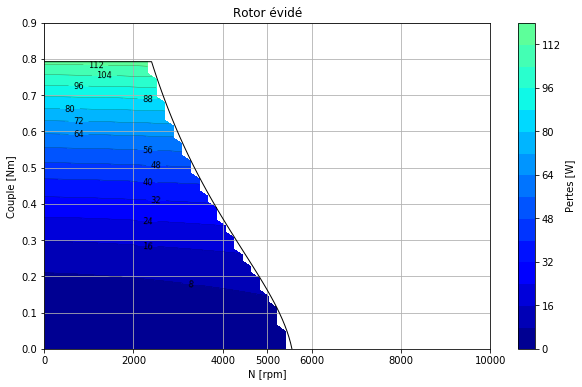

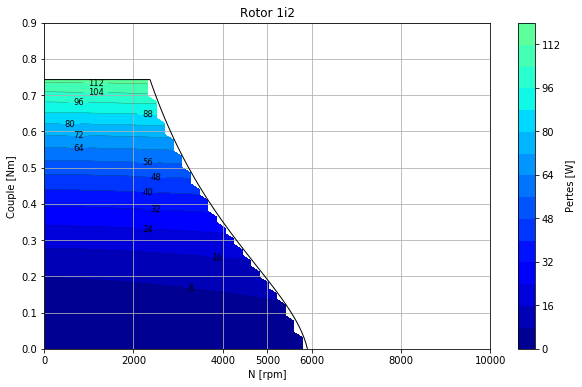

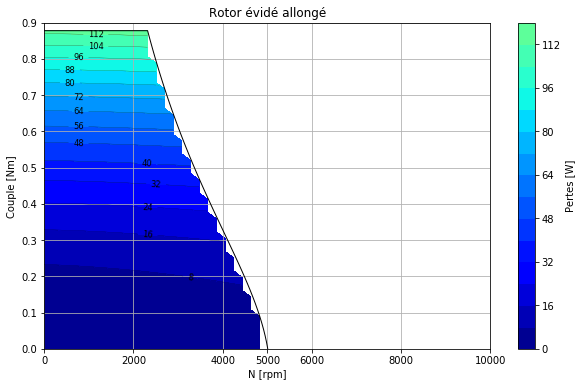

Skip
Skip
Temperature = 160°C


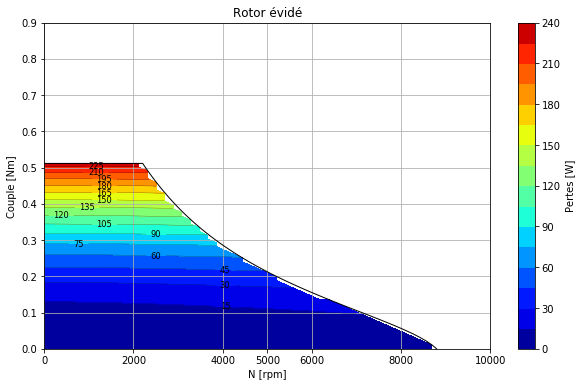

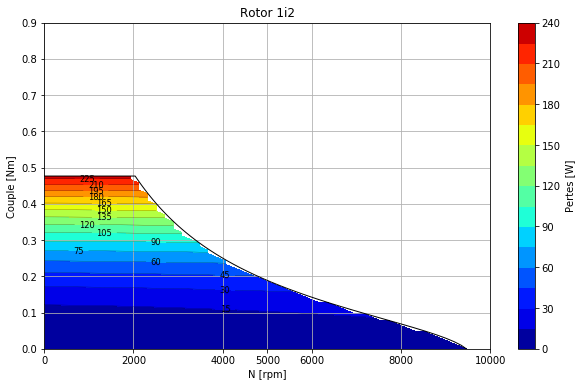

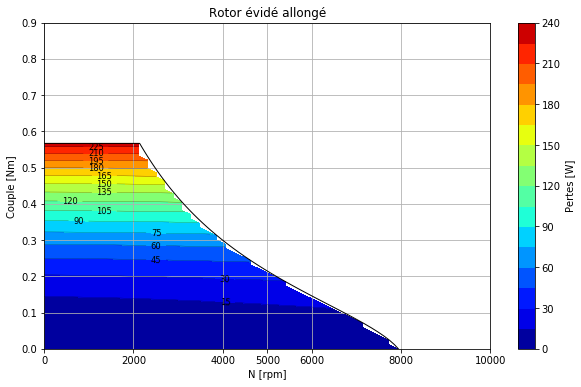

In [252]:
to_plot =  ["Rotor évidé", "Rotor 1i2", "Rotor évidé allongé"]
file_name = ["si","1i2","si_allonge"]

n_colors = 15

for i_t, t_elem in enumerate(Temp):
    if (i_t == 1)|(i_t == 2):
        print("Skip")
        continue
    print("Temperature = %i°C"%(t_elem))
    for i, elem_to_plot in enumerate(to_plot):
        # Plot
        plt.figure(figsize=(10,6))

        cs = plt.contour(NN,KT_temp[i][i_t]*II,PPertes[i_t][i], n_colors, linewidths=0.2, colors="k", vmin=0, vmax=150)
        plt.contourf(NN,KT_temp[i][i_t]*II,PPertes[i_t][i],n_colors, cmap = "jet", vmin=0, vmax=250)
        plt.plot(N_lim[i_t][i],T_lim[i_t][i],"k",linewidth=1)

        plt.xlabel("N [rpm]")
        plt.ylabel("Couple [Nm]")
        plt.xticks(list(plt.xticks()[0])+[5E+3])
        plt.title(elem_to_plot)
        plt.ylim(top = 0.9)
        plt.grid()
        plt.colorbar(label="Pertes [W]")
        plt.clabel(cs, fmt = "%i", fontsize = "smaller")
        plt.savefig("Tw_pertes_%s_%iC.pdf"%(file_name[i],t_elem))    
        plt.show()